| | |
|-|-|
| ![gym](https://github.com/nadiinchi/dl_labs/blob/master/images/gym.png?raw=1) | ![img](https://github.com/nadiinchi/dl_labs/blob/master/images/pytorch.png?raw=1) |

### Hometask

The task is complementary for the bayesian bandits task, the maximum is 5 points

1. [5 points] Implement screenshots-driven nn-based agent for a chosen Atari game.

Supplementary materials with episode lengths and total points recieved plots are expected. 

Game replay videos should be also attached.

In [1]:
%matplotlib inline

In [ ]:
import sys
!{sys.executable} -m pip install gym pygame

Agent interacts with the environment through actions (**A**), changing its state (**S**) and getting the reward (**R**).

The final goal is to maximize a total reward.

![](https://github.com/nadiinchi/dl_labs/blob/master/images/recap.png?raw=1)

# Reinforcement Learning Recap

## Cart-Pole

![](https://github.com/nadiinchi/dl_labs/blob/master/images/cartpole.png?raw=1)

* **Task** - keep the pole vertical as long as possible
* **State** - angle, rotation speed, position, velocity
* **Action** - horizontal force, applied to the cart
* **Reward** - 1 for each moment with almost-vertical pole (e.g., 85-95 degrees)

## Atari

![](https://github.com/nadiinchi/dl_labs/blob/master/images/atari.png?raw=1)

* **Task** - get as many points as possible
* **State** - game screen (screenshots)
* **Action** - various buttons
* **Reward** - is defined by a particular game

## Doom

![](https://github.com/nadiinchi/dl_labs/blob/master/images/doom.png?raw=1)

* **Target** - kill 'em all
* **State** - game screen (screenshots)
* **Action** - various buttons
* **Reward** - +1 for killing an enemy, -N for dying

## Dsicounted reward

It is common to use a discount factor $\gamma$ to give higher weights for closer rewards.

Without the dicounted factor a total reward for all the states after $t$ can be defined as

![](https://github.com/nadiinchi/dl_labs/blob/master/images/nodiscount.png?raw=1)

With the discounted factor we focus on the current rewards as the state can change in the future:

![](https://github.com/nadiinchi/dl_labs/blob/master/images/discount.png?raw=1)


## Value function

We want to know how good (valuable) each state is. It would help us to choose the best state to go.

The value function represent how good is a state for an agent to be in. It is equal to expected total reward for an agent starting from state s. The value function depends on the policy by which the agent picks actions to perform. So, if the agent uses a given policy $\pi$ to select actions, the corresponding value function is given by

![](https://github.com/nadiinchi/dl_labs/blob/master/images/vpolicy.png?raw=1)

Among all possible value-functions, there exist an **optimal value function** that has higher value than other functions for all states:

![](https://github.com/nadiinchi/dl_labs/blob/master/images/voptimal.png?raw=1)

## Q-функция

Even having optimal value functions we can't just choose the best state, only to choose an action `a`.

For better actions choice there is a quality-function Q defining the effectiveness of such actions.

$Q^\pi(s, a)$ is defined as an expected reward for making action `a` and following $\pi$ afterwards.

Just like with the value function, there is an optimal $Q^*(s, a)$

Since $V^*(s)$ is the maximum expected total reward when starting from state `s`, it will be the maximum of $Q^*(s, a)$ over all possible actions. Therefore, the relationship between $Q^*(s, a)$ and $V^*(s)$ is easily obtained as:

![](https://github.com/nadiinchi/dl_labs/blob/master/images/VQ.png?raw=1)

The optimal strategy is therefore derived from the optimal $Q$:

![](https://github.com/nadiinchi/dl_labs/blob/master/images/pioptimal.png?raw=1)

As the result **the task** of optimal strategy search for an agent **is** reduced to **defining $V^*$ и $Q^*$**.

## Q-learning

$Q(s, a)$ is defined recursevly through the Bellman equation as

![](https://github.com/nadiinchi/dl_labs/blob/master/images/bellman.png?raw=1)

The Q-learning idea is to estimate Q iteratively w.r.t. the Bellman equation:

![](https://github.com/nadiinchi/dl_labs/blob/master/images/qiter.png?raw=1)

The initial approximations will be random but the more the agent knows the closer we are to $Q^*$.

# "Handmade" environment

![](https://github.com/nadiinchi/dl_labs/blob/master/images/zombie.png?raw=1)

We want to find an icecream and not to be eaten by zombie at the same time.

Our action is chosen from 4 directions to go from the current cell.

Initial state:

In [1]:
ZOMBIE = "z"
CAR = "c"
ICE_CREAM = "i"
EMPTY = "*"

grid = [
    [ICE_CREAM, EMPTY],
    [ZOMBIE, CAR]
]

for row in grid:
    print(' '.join(row))

i *
z c


State class

In [2]:
class State:
    def __init__(self, grid, car_pos):
        self.grid = grid
        self.car_pos = car_pos
        
    def __eq__(self, other):
        return isinstance(other, State) and self.grid == other.grid and self.car_pos == other.car_pos
    
    def __hash__(self):
        return hash(str(self.grid) + str(self.car_pos))

    def __str__(self):
        return f"State(grid={self.grid}, car_pos={self.car_pos})"

    def __repr__(self):
        return self.__str__()

Actions

In [3]:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

ACTIONS = [UP, DOWN, LEFT, RIGHT]

Initial state

In [4]:
start_state = State(grid=grid, car_pos=[1, 1])
start_state

State(grid=[['i', '*'], ['z', 'c']], car_pos=[1, 1])

Action functions

In [5]:
from copy import deepcopy

def act(state, action):
    def new_car_pos(state, action):
        p = deepcopy(state.car_pos)
        if action == UP:
            p[0] = max(0, p[0] - 1)
        elif action == DOWN:
            p[0] = min(len(state.grid) - 1, p[0] + 1)
        elif action == LEFT:
            p[1] = max(0, p[1] - 1)
        elif action == RIGHT:
            p[1] = min(len(state.grid[0]) - 1, p[1] + 1)
        else:
            raise ValueError(f"Unknown action {action}")
        return p

    p = new_car_pos(state, action)
    grid_item = state.grid[p[0]][p[1]]
    
    new_grid = deepcopy(state.grid)
    
    if grid_item == ZOMBIE:
        reward = -100
        is_done = True
        new_grid[p[0]][p[1]] += CAR
    elif grid_item == ICE_CREAM:
        reward = 1000
        is_done = True
        new_grid[p[0]][p[1]] += CAR
    elif grid_item == EMPTY:
        reward = -1
        is_done = False
        old = state.car_pos
        new_grid[old[0]][old[1]] = EMPTY
        new_grid[p[0]][p[1]] = CAR
    elif grid_item == CAR:
        reward = -1
        is_done = False
    else:
        raise ValueError(f"Unknown grid item {grid_item}")

    return State(grid=new_grid, car_pos=p), reward, is_done

Training

In [6]:
import numpy as np
import random

random.seed(42)

N_STATES = 4
N_EPISODES = 20

MAX_EPISODE_STEPS = 100

MIN_ALPHA = 0.02

alphas = np.linspace(1.0, MIN_ALPHA, N_EPISODES)
gamma = 1.0
eps = 0.2

q_table = dict()

In [9]:
def q(state, action=None):
    if state not in q_table:
        q_table[state] = np.zeros(len(ACTIONS))

    if action is None:
        return q_table[state]

    return q_table[state][action]

In [10]:
def choose_action(state):
    if random.uniform(0, 1) < eps:
        return random.choice(ACTIONS) 
    else:
        return np.argmax(q(state))

In [11]:
for e in range(N_EPISODES):
    state = start_state
    total_reward = 0
    alpha = alphas[e]

    for _ in range(MAX_EPISODE_STEPS):
        action = choose_action(state)
        next_state, reward, done = act(state, action)
        total_reward += reward

        q(state)[action] = q(state, action) + \
                alpha * (reward + gamma *  np.max(q(next_state)) - q(state, action))
        state = next_state
        if done:
            break
    print(f"Episode {e + 1}: total reward -> {total_reward}")

Episode 1: total reward -> -100
Episode 2: total reward -> 994
Episode 3: total reward -> 996
Episode 4: total reward -> 999
Episode 5: total reward -> 999
Episode 6: total reward -> 998
Episode 7: total reward -> -101
Episode 8: total reward -> 999
Episode 9: total reward -> 999
Episode 10: total reward -> 999
Episode 11: total reward -> 999
Episode 12: total reward -> 999
Episode 13: total reward -> 999
Episode 14: total reward -> 998
Episode 15: total reward -> 999
Episode 16: total reward -> 999
Episode 17: total reward -> 999
Episode 18: total reward -> 999
Episode 19: total reward -> 999
Episode 20: total reward -> 996


In [12]:
q_table

{State(grid=[['i', '*'], ['z', 'c']], car_pos=[1, 1]): array([ 998.99355739,  327.50691911, -100.        ,  917.17330766]),
 State(grid=[['i', '*'], ['zc', 'c']], car_pos=[1, 0]): array([0., 0., 0., 0.]),
 State(grid=[['i', 'c'], ['z', '*']], car_pos=[0, 1]): array([-9.48421053e-01,  1.90304159e+01,  9.99999865e+02,  0.00000000e+00]),
 State(grid=[['ic', 'c'], ['z', '*']], car_pos=[0, 0]): array([0., 0., 0., 0.])}

In [13]:
start_state

State(grid=[['i', '*'], ['z', 'c']], car_pos=[1, 1])

In [14]:
state_1 = act(start_state, choose_action(start_state))[0]
state_1

State(grid=[['i', 'c'], ['z', '*']], car_pos=[0, 1])

In [15]:
state_2 = act(state_1, choose_action(state_1))[0]
state_2

State(grid=[['ic', 'c'], ['z', '*']], car_pos=[0, 0])

# Openai Gym

In [16]:
import gym

env = gym.make('CartPole-v1', render_mode='rgb_array')

In [17]:
env.reset()
done = False

for t in range(500):
    screen = env.render()
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    if done:
        observation = env.reset()
env.close()

In [18]:
import matplotlib.pyplot as plt

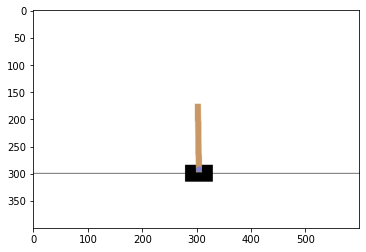

In [19]:
plt.imshow(screen)

In [19]:
observation

array([ 0.08935871,  0.36317724, -0.06021257, -0.5671515 ], dtype=float32)

In [20]:
reward

1.0

In [21]:
done

False

In [22]:
info

{}

In [31]:
def demo(name, n_episodes=10):
    env = gym.make(name)
    try:
        for i_episode in range(n_episodes):
            observation = env.reset()
            for t in range(100):
                env.render()
                action = env.action_space.sample()
                observation, reward, done, _, info = env.step(action)
                if done:
                    print("Episode finished after {} timesteps".format(t+1))
                    break
    finally:
        env.close()

In [20]:
print(env.action_space)

Discrete(2)


In [21]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [22]:
print(env.observation_space.high)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [23]:
print(env.observation_space.low)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [36]:
from gym import spaces
space = spaces.Discrete(8) # Set with 8 elements {0, 1, 2, ..., 7}
x = space.sample()
assert space.contains(x)
assert space.n == 8

# Model training

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

In [42]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda = False  # torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
BoolTensor = torch.cuda.BoolTensor if use_cuda else torch.BoolTensor
Tensor = FloatTensor

/home/sero/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [44]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

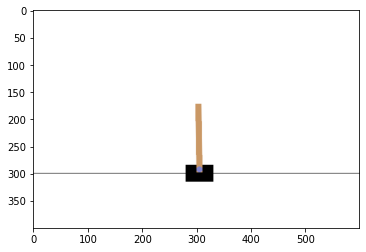

In [45]:
import gym

env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped
env.reset()
screen = env.render()
env.step(env.action_space.sample())
env.close()
plt.imshow(screen)
plt.show()

/tmp/ipykernel_6714/2390887256.py:3: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBIC),
/home/sero/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


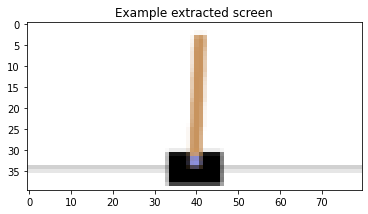

In [46]:
resize = T.Compose([
    T.ToPILImage(),
    T.Resize(40, interpolation=Image.CUBIC),
    T.ToTensor()
])
# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render().transpose((2, 0, 1))
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)



env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped
env.reset()
env.step(env.action_space.sample())
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')
plt.title('Example extracted screen')
plt.show()
env.close()

In [47]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

if use_cuda:
    policy_net.cuda()
    target_net.cuda()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state.type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])


episode_durations = []

In [48]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = BoolTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE).type(Tensor)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [49]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
    #     display.display(plt.gcf())

KeyboardInterrupt: 

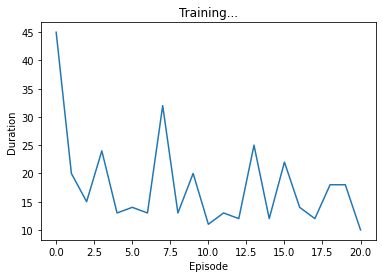

In [51]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _, info = env.step(action[0, 0].item())
        reward = Tensor([reward])

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()
plt.ioff()
plt.show()

In [52]:
tran = memory.sample(1)[0]

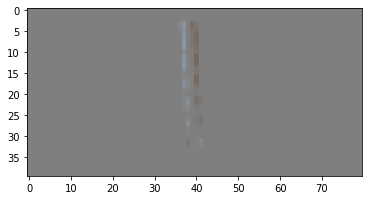

In [53]:
plt.imshow(tran.state.cpu().squeeze(0).permute(1, 2, 0).numpy() + 0.5)

In [54]:
len(memory)

376

In [55]:
env.close()

### Homework

Your goal is to achieve stable 300+ duration on CartPole task